# SPACEL workflow (1/3): Deconvolution by Spoint on mouse brain ST dataset

July 2023

Dataset: 75 ST slices of mouse brain ([here](https://zenodo.org/record/8167488))

In [1]:
import pandas as pd
import scanpy as sc
import anndata
import os
from tqdm import tqdm 
import scanpy as sc
import numpy as np
import sys

## Load spatial transcriptomics data

The input data are anndata objects stored raw counts for scRNA-seq and ST. The scRNA-seq anndata must have cell type annotation in ``.obs``.

In [2]:
adata = sc.read('/data/KanCell-main/docs/data/humanheart/Spatial.h5ad')
scadata = sc.read_h5ad('/data/KanCell-main/docs/data/humanheart/scRNA.h5ad')

/root/anaconda3/envs/SPACEL/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [4]:
scadata.var_names_make_unique()
scadata.obs_names_make_unique()

In [5]:
scadata

AnnData object with n_obs × n_vars = 3760 × 15323
    obs: 'celltype'

In [6]:
scadata.obs['celltype']

AAACCTGAGAAACCAT.1                Erythrocytes
AAACCTGGTGGTACAG.1             Fibroblast-like
AAACGGGAGATGTAAC.1             Fibroblast-like
AAACGGGAGGCAGTCA.1         Smooth muscle cells
AAACGGGAGGTCATCT.1         Smooth muscle cells
                                ...           
TTTGCGCTCCGTCATC.2       Capillary endothelium
TTTGCGCTCGGCGCTA.2             Fibroblast-like
TTTGGTTAGTGTCCAT.2    Epicardium-derived cells
TTTGTCAAGGAATCGC.2             Fibroblast-like
TTTGTCACACGGTAAG.2             Fibroblast-like
Name: celltype, Length: 3760, dtype: category
Categories (11, object): ['Atrial cardiomyocytes', 'Capillary endothelium', 'Cardiac neural crest cells & Schwann progenit..., 'Endothelium / pericytes / adventitia', ..., 'Fibroblast-like', 'Immune cells', 'Smooth muscle cells', 'Ventricular cardiomyocytes']

## Initialize and train the Spoint model

In this step, we initialize the Spoint model using anndata objects for scRNA-seq and ST as input. The``celltype_key`` parameter represents the column name of the cell type annotation in the .obs attribute of the scRNA-seq anndata object. The ``sm_size`` parameter controls the number of simulated spots, and it is important to have a sufficient ``sm_size`` for accurate prediction. However, it should be noted that increasing the ``sm_size`` will also increase the simulation and training time. In general, we recommend setting ``sm_size`` to a value greater than 100,000.

In [7]:
import KanCell
from KanCell.setting import set_environ_seed
set_environ_seed()
from KanCell import Spoint

Setting environment seed: 42


Global seed set to 0


In [8]:
spoint_model = Spoint.init_model(scadata,adata,celltype_key='celltype',sm_size=500000,use_gpu=True,n_threads=16)

Setting global seed: 42
### Finding marker genes...
celltype
Atrial cardiomyocytes                                    200
Capillary endothelium                                    200
Cardiac neural crest cells & Schwann progenitor cells    200
Endothelium / pericytes / adventitia                     200
Epicardial cells                                         200
Epicardium-derived cells                                 200
Erythrocytes                                             200
Fibroblast-like                                          200
Immune cells                                             200
Smooth muscle cells                                      200
Ventricular cardiomyocytes                               200
Name: count, dtype: int64
### Used gene numbers: 1911
### Initializing sample probability
### Genetating simulated spatial data using scRNA data with mode: unbalance
### Genetating simulated spatial data using scRNA data with mode: sqrt
### Genetating simulated spatia

In [9]:
import os,sys
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
spoint_model.train(max_steps=5000, batch_size=1024)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Epoch 3/100:   2%|▏         | 2/100 [00:17<14:07,  8.65s/it, loss=727, v_num=1]

Epoch 100/100: 100%|██████████| 100/100 [13:52<00:00,  8.19s/it, loss=666, v_num=1]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [13:52<00:00,  8.33s/it, loss=666, v_num=1]


  0%|          | 0/5000 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 512.00 MiB (GPU 0; 11.76 GiB total capacity; 1.86 GiB already allocated; 134.44 MiB free; 2.36 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

Then, we utilize the trained model to predict the cell type composition of each spot in the spatial transcriptomics data. This prediction will generate a DataFrame object, where each row corresponds to a spot in the spatial transcriptomics data, each column represents a cell type from the single-cell RNA-seq data, and each entry indicates the proportion of a particular cell type in a spot. Additionally, we can obtain the anndata object of the spatial transcriptomics data with the deconvolution results embedded in the .obs attribute.

In [ ]:
pre = spoint_model.deconv_spatial()
st_ad = spoint_model.st_ad
# st_ad.write('../data/ST_mouse_brain/mouse_brain_st.h5ad')

## Visualization results

As a demonstration, we plotted the predicted compositions of cell types on a slice, where the cell types are selected as the top 20 with the highest proportion within each spot.

In [ ]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.serif'] = ['Arial']
sc.settings.set_figure_params(dpi=50,dpi_save=300,facecolor='white',fontsize=10,vector_friendly=True,figsize=(3,3))
sc.settings.verbosity = 3

In [ ]:
st_ad

AnnData object with n_obs × n_vars = 3111 × 1911
    obs: 'n_genes', 'batch', 'Fibroblast-like', 'Capillary endothelium', 'Ventricular cardiomyocytes', 'Smooth muscle cells', 'Epicardium-derived cells', 'Erythrocytes', 'Epicardial cells', 'Endothelium / pericytes / adventitia', 'Atrial cardiomyocytes', 'Immune cells', 'Cardiac neural crest cells & Schwann progenitor cells'
    uns: 'celltypes'
    layers: 'norm'

In [ ]:
from skimage.io import imread
st_loc_file="/data/SpatialcoGCN-main/data/pseudo_STData/realdata/humanheart/Data/Human_heart_ST_location.txt"
st_loc_df = pd.read_csv(st_loc_file, sep = "\t", index_col = 0, header = 0)


# 将 DataFrame 转换为 NumPy 数组
spatial_coords = st_loc_df.values

# 将空间坐标数据存储在 adata.obsm['spatial'] 中
st_ad.obsm['spatial'] = spatial_coords

# 现在 adata.obsm['spatial'] 中应该包含了位置信息
print(st_ad.obsm['spatial'])
# adata_st_list_raw = []
# for i in range(1, 10):
img_i = imread('/data/GraphST-main/Data/humanheart/dgnysc3zn5-1/ST_Samples_9PCW/ST_Sample_9PCW_1/ST_Sample_9PCW_1_HE_small.jpg')

# 创建与示例相同结构的数据字典
st_ad.uns['spatial'] = {}
st_ad.uns['spatial']['0'] = {}
st_ad.uns['spatial']['0']['images'] = {}
st_ad.uns['spatial']['0']['images']['hires'] = img_i
st_ad.uns['spatial']['0']['scalefactors'] = {'spot_diameter_fullres': 10,
                                                'tissue_hires_scalef': 2.0,
                                                'fiducial_diameter_fullres': 100,
                                                'tissue_lowres_scalef': 1.0}

    # 现在 adata.obsm 中应该包含了位置信息
print(st_ad.uns['spatial'])


[[17 20  1]
 [17 21  1]
 [17 22  1]
 ...
 [ 9 13 19]
 [ 9  8 19]
 [ 9  9 19]]
{'0': {'images': {'hires': array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
       

In [ ]:
# st_ad = st_ad[st_ad.obs.slice==37]
celltype = st_ad.obs.loc[:,pre.columns].max(0)

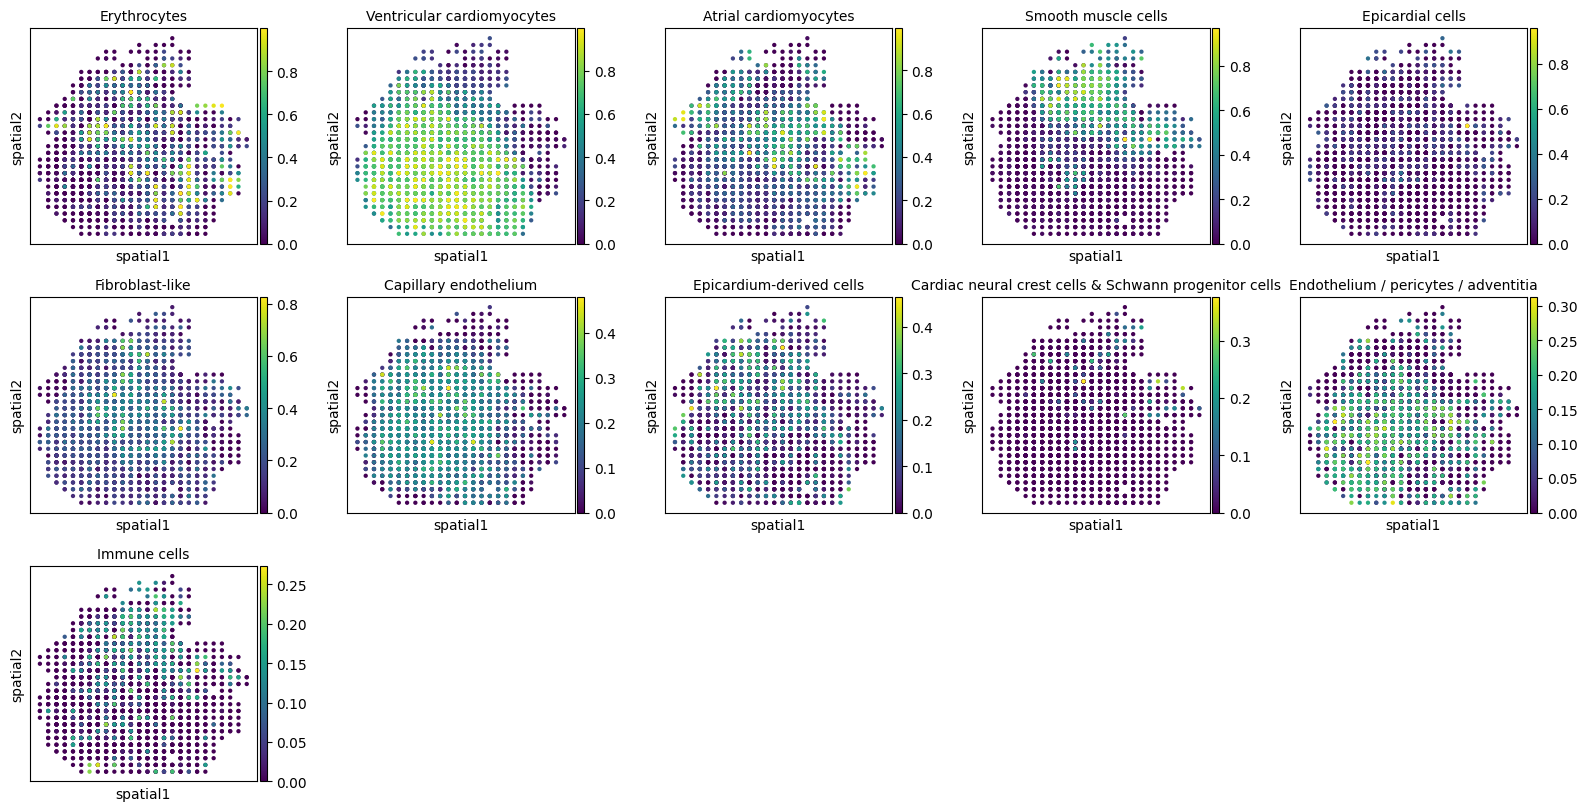

In [ ]:
sc.pl.embedding(st_ad,color=celltype.sort_values(ascending=False)[:20].index,basis='spatial',ncols=5)

In [ ]:
pre.to_csv('/data/SpatialcoGCN-main/data/pseudo_STData/realdata/humanheart/results/spacel_data.csv', index=False,float_format='%.6f')

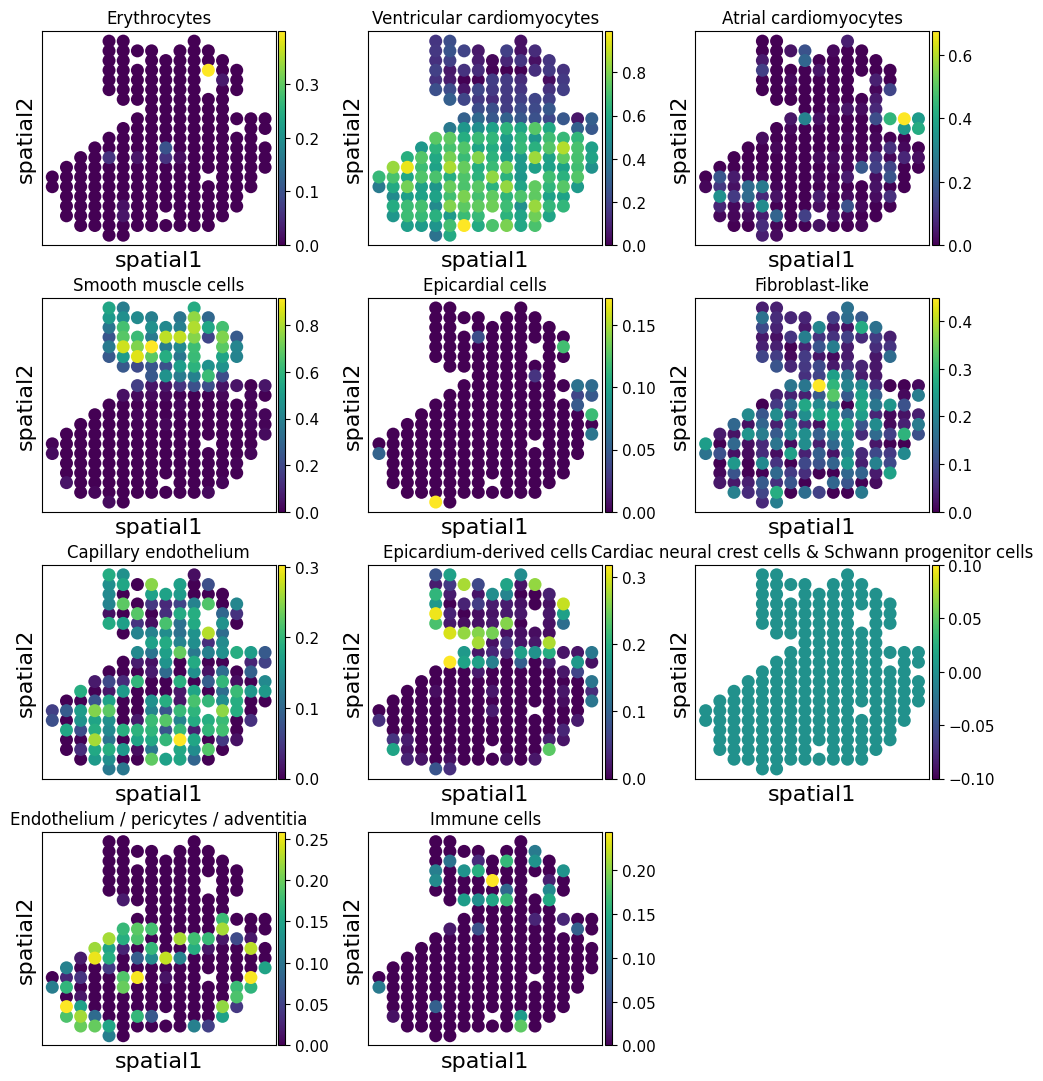

In [ ]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

# 读取数据
st_loc_file = "/data/SpatialcoGCN-main/data/pseudo_STData/realdata/humanheart/Data/Human_heart_ST_location.txt"
st_loc_df = pd.read_csv(st_loc_file, sep="\t", index_col=0, header=0)

# 将第三列转换为字符串类型
st_loc_df.iloc[:, 2] = st_loc_df.iloc[:, 2].astype(str)

# 对第三列进行筛选，只保留值为 "9" 的行
filtered_data = st_loc_df[st_loc_df.iloc[:, 2] == "19"]

# 使用筛选后的索引来从原始数据中获取想要的数据
filtered_adata = st_ad[filtered_data.index]

# 更新字体大小
plt.rcParams.update({'font.size': 14})  # 设置全局字体大小

# 绘制嵌入图，并调整颜色
sc.pl.embedding(
    filtered_adata, 
    color=celltype.sort_values(ascending=False)[:20].index, 
    basis='spatial', 
    ncols=3, 
    s=350, 
    size=10, 
    show=False
)

# 调整子图之间的间距
plt.subplots_adjust(wspace=0.9, hspace=0.8)  # 调整水平和垂直间距

# 调整每个子图的字体大小
fig = plt.gcf()
axes = fig.get_axes()
for ax in axes:
    ax.title.set_size(12)  # 设置标题字体大小
    ax.xaxis.label.set_size(16)  # 设置x轴标签字体大小
    ax.yaxis.label.set_size(16)  # 设置y轴标签字体大小
    ax.tick_params(axis='both', which='major', labelsize=11)  # 设置刻度字体大小

# 显示图像
plt.show()


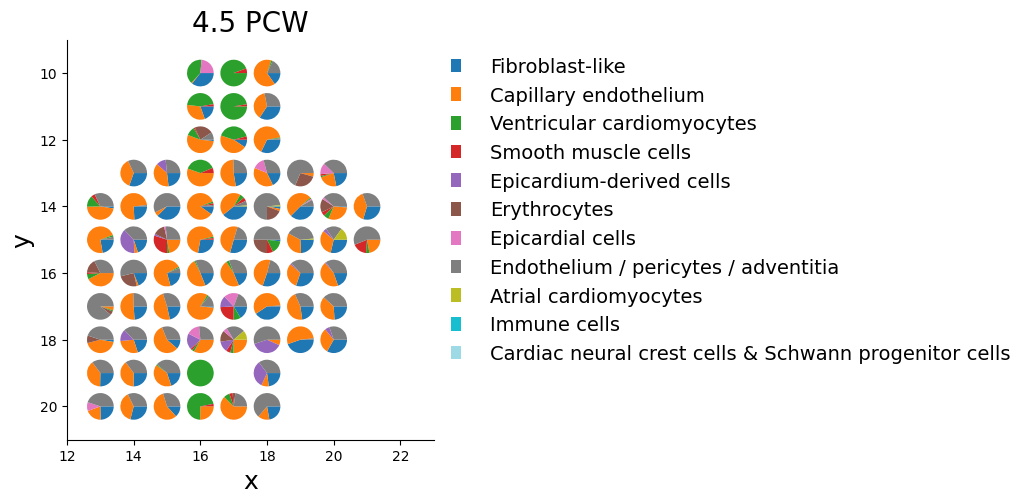

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge

# 读取位置文件
st_loc_file = "/data/SpatialcoGCN-main/data/pseudo_STData/realdata/humanheart/Data/Human_heart_ST_location.txt"
st_loc_df = pd.read_csv(st_loc_file, sep="\t", index_col=0, header=0)
st_loc_df.iloc[:, 2] = st_loc_df.iloc[:, 2].astype(str)
st_loc_df = st_loc_df[st_loc_df.iloc[:, 2] == "3"]

# 读取预测文件
predicted_values = pd.read_csv('/data/SpatialcoGCN-main/data/pseudo_STData/realdata/humanheart/results/spacel_data.csv')

# 重置索引
st_loc_df.reset_index(drop=True, inplace=True)
predicted_values.reset_index(drop=True, inplace=True)

# 合并数据
merged_data = pd.concat([st_loc_df, predicted_values], axis=1)

# 确保所有细胞类型数据列都是数值类型
for col in merged_data.columns[4:]:
    merged_data[col] = pd.to_numeric(merged_data[col], errors='coerce')

# 确保 X 和 Y 列是数值类型
merged_data['X'] = pd.to_numeric(merged_data['X'], errors='coerce')
merged_data['Y'] = pd.to_numeric(merged_data['Y'], errors='coerce')

# 删除包含缺失值的行
merged_data.dropna(subset=['X', 'Y'], inplace=True)

# 定义绘制饼图的函数
def draw_pie(ax, sizes, x, y, colors):
    start_angle = 0
    radius = 0.4  # 缩小饼图的半径
    for size, color in zip(sizes, colors):
        if size > 0:  # 仅绘制比例大于0的部分
            angle = size * 360
            wedge = Wedge((x, y), radius, start_angle, start_angle + angle, facecolor=color)
            ax.add_patch(wedge)
            start_angle += angle

# 使用 plt.cm.tab20 调色板
num_cell_types = predicted_values.shape[1]
colors = plt.cm.tab20(np.linspace(0, 1, num_cell_types))

# 创建绘图
fig, ax = plt.subplots(figsize=(12, 5))
for _, row in merged_data.iterrows():
    sizes = row[4:]  # 细胞类型的比例数据
    sizes = sizes / sizes.sum()  # 归一化
    x = row['X']
    y = row['Y']
    draw_pie(ax, sizes, x, y, colors)

# 设置标题和标签
ax.set_title('4.5 PCW', fontsize=20)
ax.set_xlabel('x', fontsize=18)
ax.set_ylabel('y', fontsize=18)

# 设置坐标轴
ax.set_xlim(12, 23)
ax.set_ylim(9, 21)
ax.set_aspect('equal')
ax.invert_yaxis()  # 翻转y轴
plt.grid(False)

# 去掉顶部和右侧的坐标轴线
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# 添加图例
cell_types = predicted_values.columns
handles = [Wedge((0, 0), 1, 0, 360, facecolor=color) for color in colors]
legend = ax.legend(handles, cell_types, loc='upper left', bbox_to_anchor=(1, 1), frameon=False, fontsize=14, handletextpad=1.5, columnspacing=2)

# 调整图表布局
plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)

# 显示图表
plt.show()


In [ ]:
import scanpy as sc
import gseapy as gp
import pandas as pd
import matplotlib.pyplot as plt

# 读取数据
scadata = sc.read_h5ad('/data/SpatialcoGCN-main/data/pseudo_STData/realdata/humanheart/scRNA.h5ad')

# 提取特定细胞类型的数据
cells = scadata

# 计算基因表达量均值，并选取前20个基因
mean_expression = cells.X.mean(axis=0).flatten()
top_genes_idx = mean_expression.argsort()[-20:][::-1]
top_genes = cells.var_names[top_genes_idx]

# 去掉前缀
top_genes = [gene.replace('GENE_', '') for gene in top_genes]

print("Top genes:", top_genes)


Top genes: ['EEF1A1', 'RPL10', 'RPL13A', 'RPLP1', 'TMSB4X', 'RPS2', 'MT-CO1', 'RPS18', 'RPL13', 'VIM', 'TPT1', 'MT-CO3', 'RPS12', 'RPS4X', 'RPL41', 'TMSB10', 'RPS23', 'RPL32', 'RPS14', 'RPS8']


In [ ]:
import scanpy as sc
import gseapy as gp
import pandas as pd

# 读取数据
scadata = sc.read_h5ad('/data/Celloc-main/data/CytoSPACE_example_breast_cancer/scRNA.h5ad')

# 提取特定细胞类型的数据
cells = scadata

# 计算基因表达量均值，并选取前20个基因
mean_expression = cells.X.mean(axis=0).flatten()
top_genes_idx = mean_expression.argsort()[-20:][::-1]
top_genes = cells.var_names[top_genes_idx]

# 去掉前缀
top_genes = [gene.replace('GENE_', '') for gene in top_genes]

# 使用gseapy进行富集分析
enr = gp.enrichr(gene_list=top_genes, 
                 gene_sets=['DisGeNET'],  # 选择DisGeNET数据库
                 organism='Human', 
                 outdir=None)

# 提取富集结果
disease_results = enr.results

# 过滤与心脏相关的疾病
heart_related_terms = ['cardiac', 'heart', 'cardiomyopathy', 'arrhythmia', 'myocardial', 'coronary']
heart_disease_results = disease_results[disease_results['Term'].str.contains('|'.join(heart_related_terms), case=False)]

# 打印前20个关联疾病
top_heart_diseases = heart_disease_results.head(20)
print("Top 20 Heart-Related Disease Associations:")
print(top_heart_diseases)

# 保存结果为CSV文件
top_heart_diseases.to_csv('/data/SPACEL-l/docs/tutorials/xlsx/top_20_heart_related_diseases.csv', index=False)


Top 20 Heart-Related Disease Associations:
      Gene_set                                    Term Overlap   P-value  \
181   DisGeNET                          Heart Diseases   3/325  0.003948   
265   DisGeNET               Old myocardial infarction     1/8  0.007973   
555   DisGeNET                        Cardiac Lymphoma    1/29  0.028617   
652   DisGeNET                 Rheumatic Heart Disease    1/41  0.040230   
672   DisGeNET             Hypertrophic Cardiomyopathy   2/328  0.041947   
755   DisGeNET     Cardiomyopathy, Familial Idiopathic   2/388  0.056677   
805   DisGeNET                 Cardiomyopathy, Dilated   2/419  0.064910   
834   DisGeNET  Cardiomyopathy, Hypertrophic, Familial    1/73  0.070555   
841   DisGeNET                 Coronary Artery Disease   3/981  0.072029   
845   DisGeNET                     Myocardial Ischemia   2/448  0.072960   
846   DisGeNET         Familial dilated cardiomyopathy    1/76  0.073351   
938   DisGeNET                      Myocardia

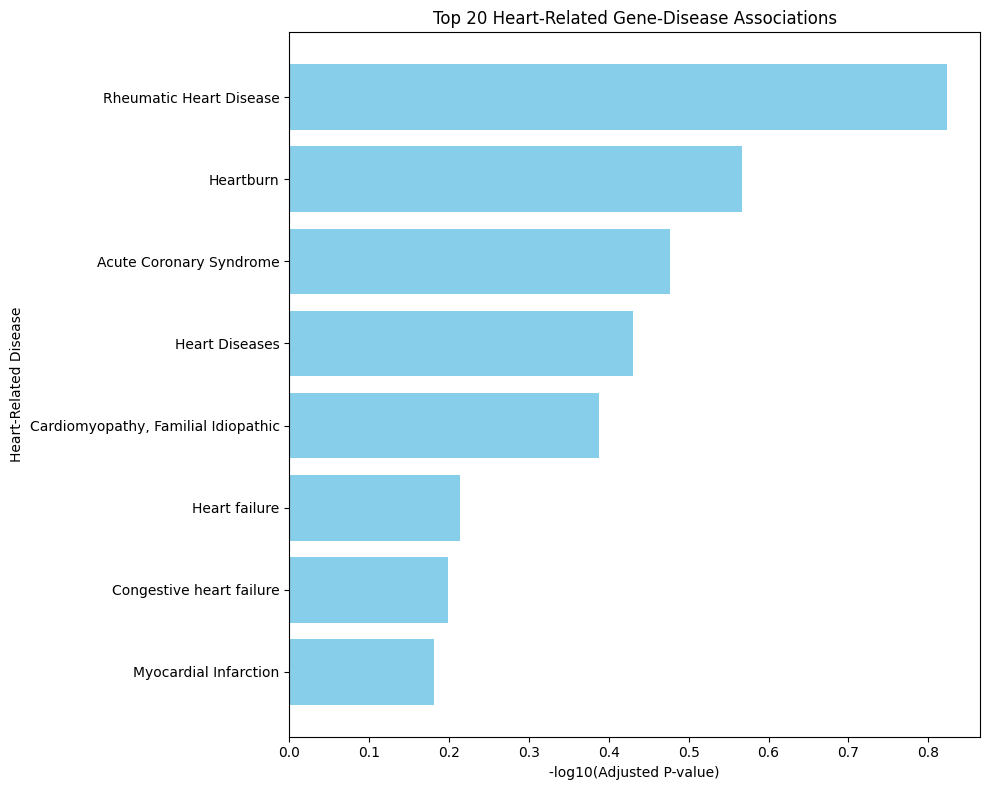

In [ ]:
# 绘制条形图
plt.figure(figsize=(10, 8))
plt.barh(top_heart_diseases['Term'], -np.log10(top_heart_diseases['Adjusted P-value']), color='skyblue')
plt.xlabel('-log10(Adjusted P-value)')
plt.ylabel('Heart-Related Disease')
plt.title('Top 20 Heart-Related Gene-Disease Associations')
plt.gca().invert_yaxis()  # 翻转Y轴使最显著的疾病位于顶部
plt.tight_layout()
plt.show()


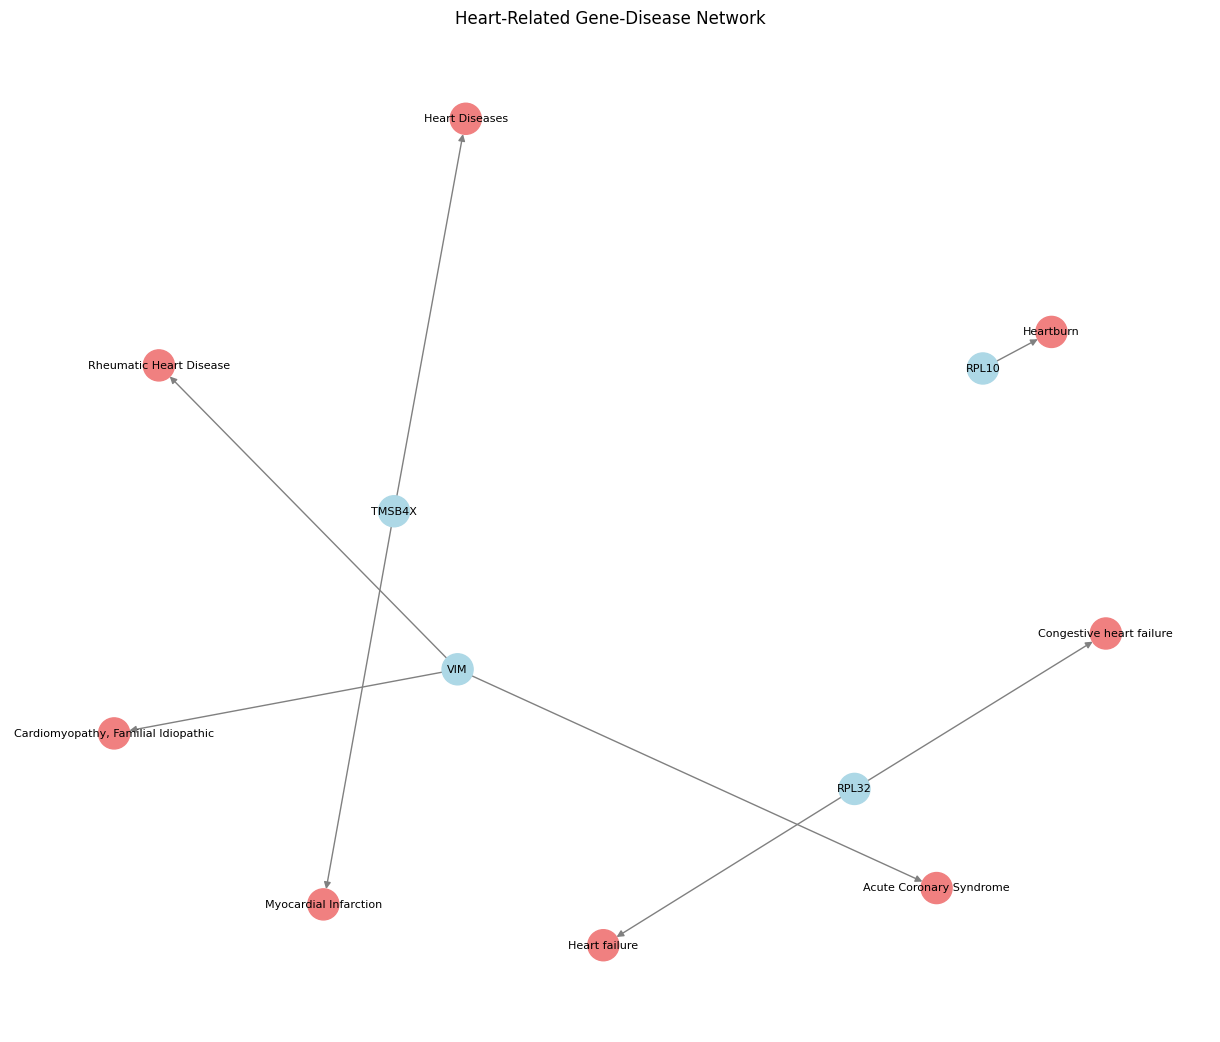

In [ ]:
import networkx as nx

# 创建图
G = nx.DiGraph()

# 添加基因和疾病节点以及边
for _, row in top_heart_diseases.iterrows():
    disease = row['Term']
    genes_in_disease = row['Genes'].split(';')
    for gene in genes_in_disease:
        if gene in top_genes:
            G.add_edge(gene, disease)
            G.nodes[gene]['type'] = 'gene'
            G.nodes[disease]['type'] = 'disease'

# 设置节点颜色
node_color = ['lightblue' if G.nodes[node]['type'] == 'gene' else 'lightcoral' for node in G.nodes()]

# 绘制网络
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color=node_color, edge_color='gray', node_size=500, font_size=8)
plt.title('Heart-Related Gene-Disease Network')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 提取前20个富集的GO生物过程
top_20_pathways = combined_results.sort_values(by='Adjusted P-value').head(20)

# 提取生物过程名称和对应的调整后P值
terms = top_20_pathways['Term']
adjusted_pvalues = top_20_pathways['Adjusted P-value']

# 绘制条形图
plt.figure(figsize=(10, 8))
plt.barh(terms, -np.log10(adjusted_pvalues), color='skyblue')
plt.xlabel('-log10(Adjusted P-value)')
plt.ylabel('GO Biological Process')
plt.title('Top 20 Enriched GO Biological Processes')
plt.gca().invert_yaxis()  # 翻转Y轴使最显著的通路位于顶部
plt.tight_layout()

# 保存图片
# plt.savefig('/mnt/data/top_20_enriched_go_biological_processes.png')
plt.show()


NameError: name 'combined_results' is not defined

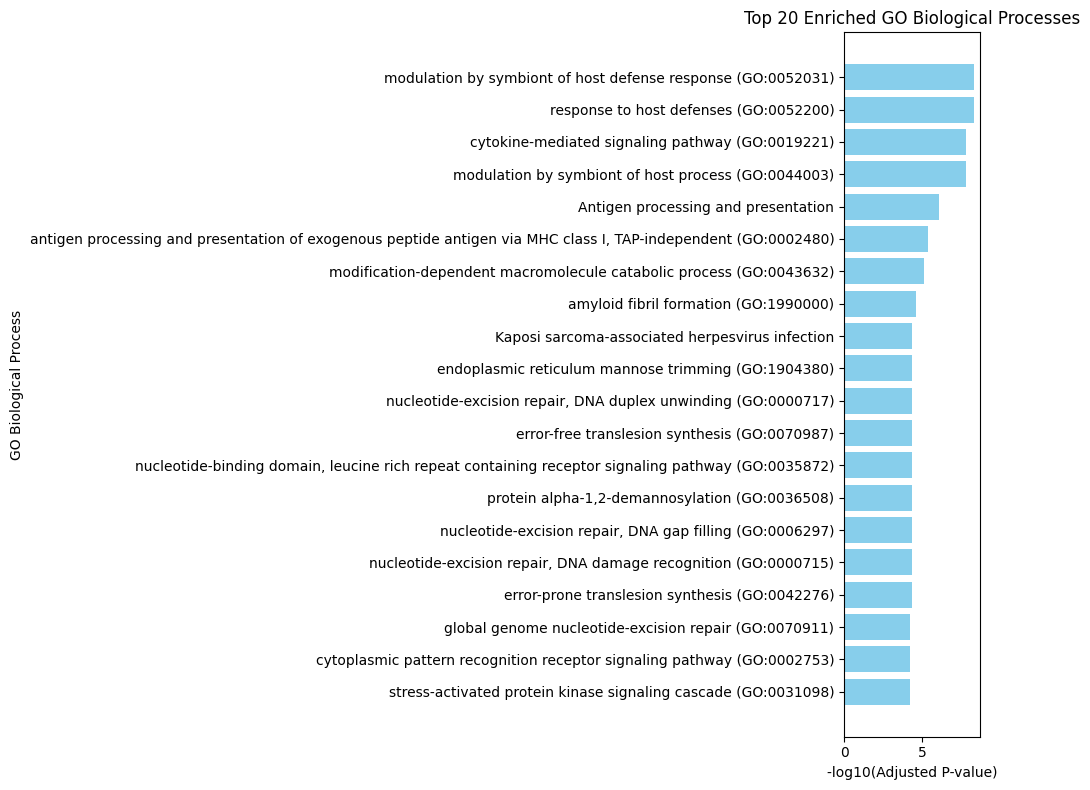

In [ ]:
import scanpy as sc
import gseapy as gp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 读取数据
scadata = sc.read_h5ad('/data/Celloc-main/data/CytoSPACE_example_breast_cancer/scRNA.h5ad')

# 提取特定细胞类型的数据
cells = scadata

# 计算基因表达量均值，并选取前20个基因
mean_expression = cells.X.mean(axis=0).flatten()
top_genes_idx = mean_expression.argsort()[-20:][::-1]
top_genes = cells.var_names[top_genes_idx]

# 去掉前缀
top_genes = [gene.replace('GENE_', '') for gene in top_genes]

# 使用gseapy进行富集分析
gene_sets = ['KEGG_2021_Human', 'GO_Biological_Process_2021']
enrichment_results = []

for gene_set in gene_sets:
    try:
        enr = gp.enrichr(gene_list=top_genes, 
                         gene_sets=[gene_set],  # 选择合适的基因集
                         organism='Human',
                         outdir=None)
        enrichment_results.append(enr.results)
    except Exception as e:
        print(f"Error during enrichment analysis with gene set {gene_set}:", e)

# 合并富集结果并只展示前20个通路
combined_results = pd.concat(enrichment_results)

# 提取前20个富集的GO生物过程
top_20_pathways = combined_results.sort_values(by='Adjusted P-value').head(20)

# 提取生物过程名称和对应的调整后P值
terms = top_20_pathways['Term']
adjusted_pvalues = top_20_pathways['Adjusted P-value']

# 绘制条形图
plt.figure(figsize=(10, 8))
plt.barh(terms, -np.log10(adjusted_pvalues), color='skyblue')
plt.xlabel('-log10(Adjusted P-value)')
plt.ylabel('GO Biological Process')
plt.title('Top 20 Enriched GO Biological Processes')
plt.gca().invert_yaxis()  # 翻转Y轴使最显著的通路位于顶部
plt.tight_layout()

# 保存图片
# plt.savefig('/mnt/data/top_20_enriched_go_biological_processes.png')
plt.show()


In [ ]:
scadata

AnnData object with n_obs × n_vars = 3977 × 3875
    obs: 'CellType', 'leiden', 'dpt_pseudotime'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'pca', 'hvg', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'iroot', 'diffmap_evals'
    obsm: 'X_pca', 'X_umap', 'X_diffmap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/root/anaconda3/envs/SPACEL/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/root/anaconda3/envs/SPACEL/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


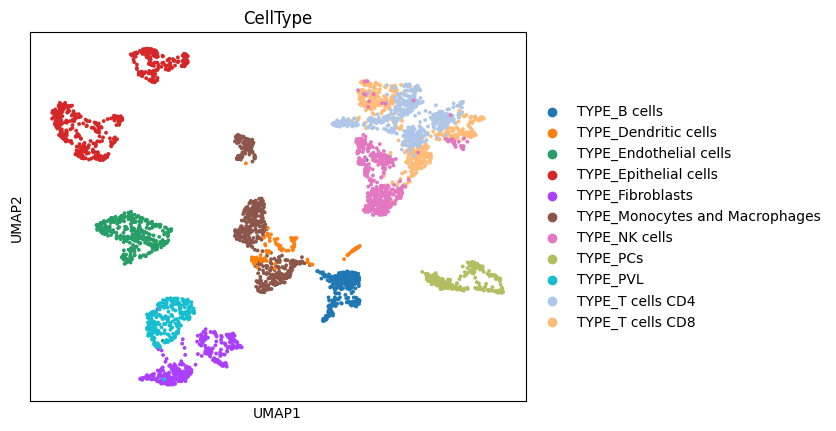

In [ ]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 读取数据
scadata = sc.read_h5ad('/data/Celloc-main/data/CytoSPACE_example_breast_cancer/scRNA.h5ad')

# 数据预处理
sc.pp.normalize_total(scadata, target_sum=1e4)
sc.pp.log1p(scadata)
sc.pp.highly_variable_genes(scadata, min_mean=0.0125, max_mean=3, min_disp=0.5)
scadata = scadata[:, scadata.var.highly_variable]
sc.pp.scale(scadata, max_value=10)
sc.tl.pca(scadata, svd_solver='arpack')
sc.pp.neighbors(scadata, n_neighbors=10, n_pcs=40)
sc.tl.umap(scadata)
sc.tl.leiden(scadata)

# 可视化UMAP聚类结果
sc.pl.umap(scadata, color=['CellType'])


In [ ]:
scadata.obs['CellType']

CELL_CID3921_AAAGATGGTGAGGCTA     TYPE_Endothelial cells
CELL_CID3921_AAAGATGTCCATGAGT     TYPE_Endothelial cells
CELL_CID3921_AACCATGCAGTAACGG     TYPE_Endothelial cells
CELL_CID3921_AACCGCGGTCAGAATA     TYPE_Endothelial cells
CELL_CID3921_AACGTTGTCAGCTGGC     TYPE_Endothelial cells
                                           ...          
CELL_CID45171_CTGCTGTTCCTTTCGG     TYPE_Epithelial cells
CELL_CID3921_TCTTTCCTCCGAACGC      TYPE_Epithelial cells
CELL_CID45171_TATTACCTCGACCAGC     TYPE_Epithelial cells
CELL_CID3921_CTCATTATCTGTCTAT      TYPE_Epithelial cells
CELL_CID3921_GATCGTACACAGATTC      TYPE_Epithelial cells
Name: CellType, Length: 3977, dtype: category
Categories (11, object): ['TYPE_B cells', 'TYPE_Dendritic cells', 'TYPE_Endothelial cells', 'TYPE_Epithelial cells', ..., 'TYPE_PCs', 'TYPE_PVL', 'TYPE_T cells CD4', 'TYPE_T cells CD8']

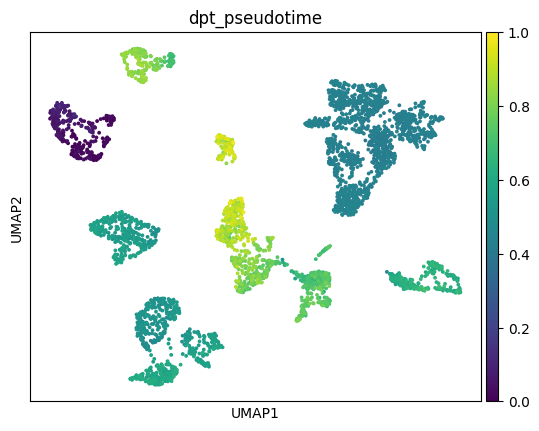

In [ ]:
# 选择起始细胞
root_cell = np.where(scadata.obs['CellType'] == 'TYPE_Epithelial cells')[0][0]  # 修改 '0' 为适合你数据的类簇

# 设置根细胞
scadata.uns['iroot'] = root_cell

# 计算拟时序
sc.tl.dpt(scadata)

# 可视化拟时序
sc.pl.umap(scadata, color='dpt_pseudotime', cmap='viridis')


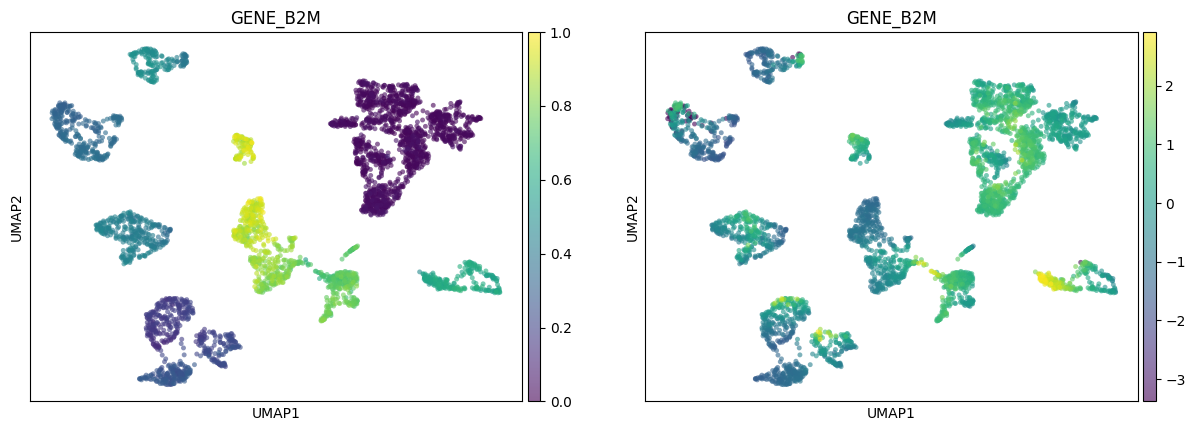

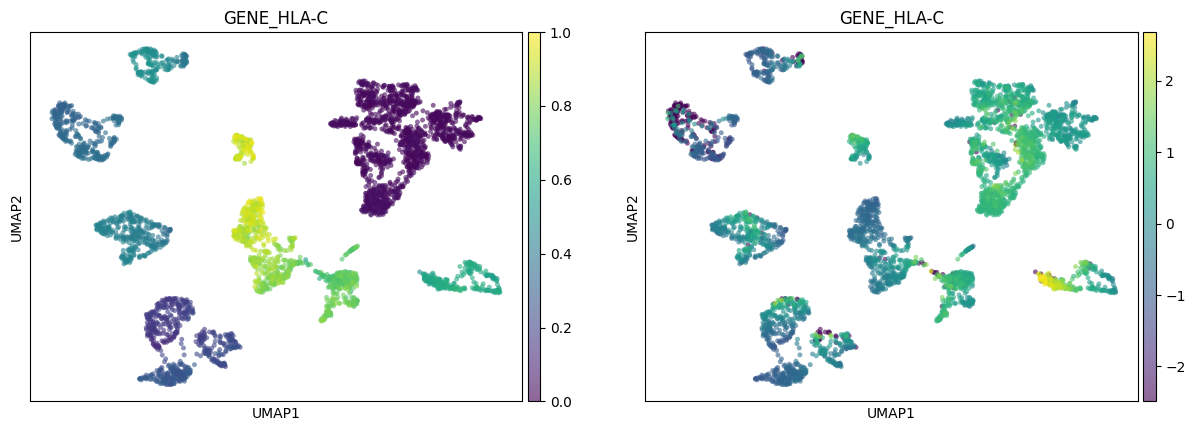

In [ ]:
# 可视化特定基因随拟时序的表达变化
genes = ['GENE_B2M', 'GENE_HLA-C']  # 替换为你感兴趣的基因

# 使用UMAP绘制基因表达随拟时序的变化
for gene in genes:
    sc.pl.umap(scadata, color=['dpt_pseudotime', gene], color_map='viridis', s=50, alpha=0.6, title=gene)


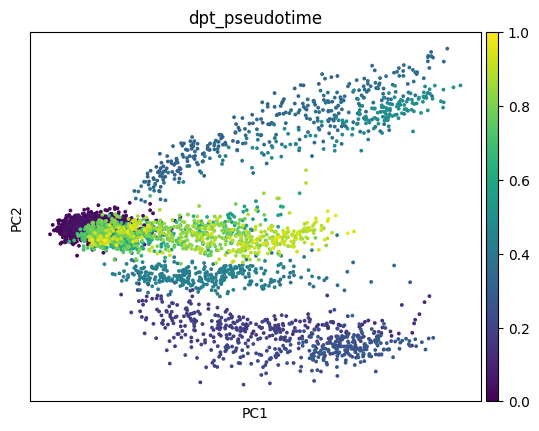

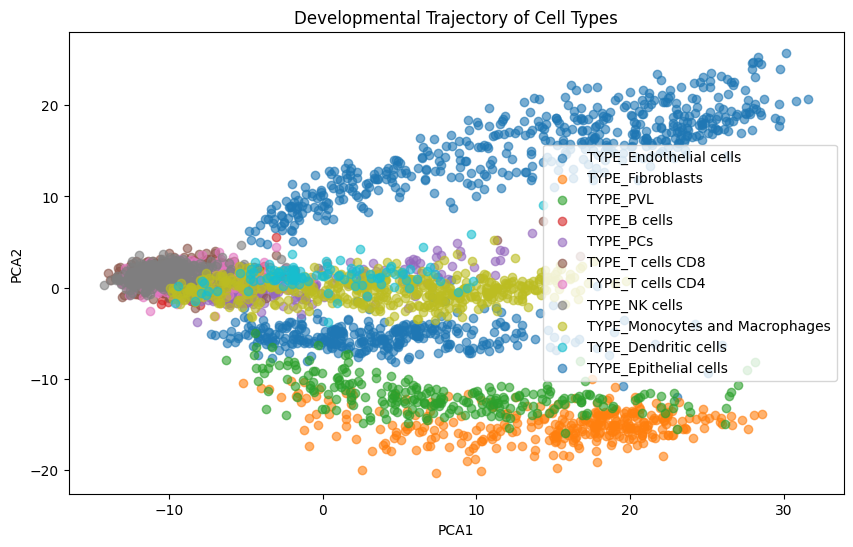

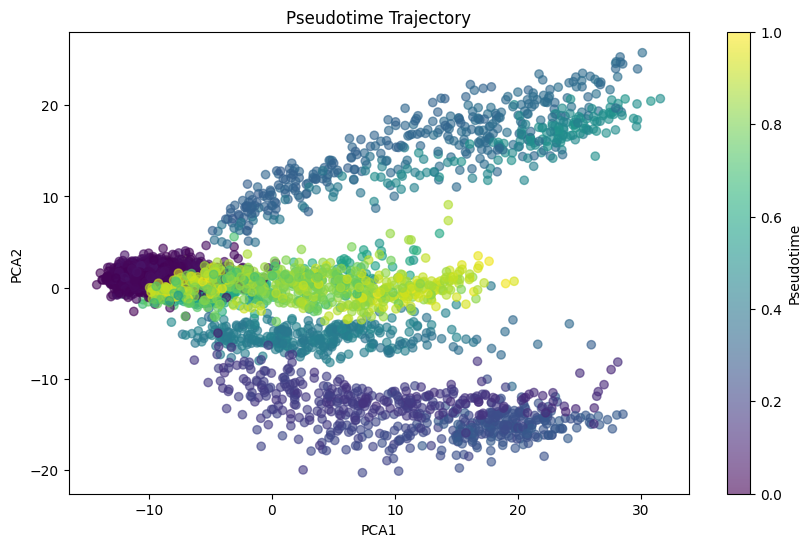

In [ ]:
# 选择起始细胞
root_cell = np.where(scadata.obs['leiden'] == '0')[0][0]  # 修改 '0' 为适合你数据的类簇

# 设置根细胞
scadata.uns['iroot'] = root_cell

# 计算拟时序
sc.tl.dpt(scadata)

# 确保 CellType 列存在
if 'CellType' in scadata.obs.columns:
    # 创建一个包含细胞类型和拟时序信息的DataFrame
    df = pd.DataFrame({
        'CellType': scadata.obs['CellType'],
        'Pseudotime': scadata.obs['dpt_pseudotime']
    })

    # 绘制细胞类型和拟时序的PCA图
    sc.tl.pca(scadata, svd_solver='arpack')
    sc.pl.pca(scadata, color='dpt_pseudotime', cmap='viridis')

    # 绘制细胞类型和拟时序的发育轨迹图
    plt.figure(figsize=(10, 6))
    for cell_type in df['CellType'].unique():
        idx = df['CellType'] == cell_type
        plt.scatter(scadata.obsm['X_pca'][idx, 0], scadata.obsm['X_pca'][idx, 1], label=cell_type, alpha=0.6)
    
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.title('Developmental Trajectory of Cell Types')
    plt.legend(loc='best')
    plt.show()

    # 绘制拟时序的发育轨迹图
    plt.figure(figsize=(10, 6))
    plt.scatter(scadata.obsm['X_pca'][:, 0], scadata.obsm['X_pca'][:, 1], c=scadata.obs['dpt_pseudotime'], cmap='viridis', alpha=0.6)
    plt.colorbar(label='Pseudotime')
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.title('Pseudotime Trajectory')
    plt.show()
else:
    print("CellType列不存在于scadata.obs中，请检查数据。")


/root/anaconda3/envs/SPACEL/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/root/anaconda3/envs/SPACEL/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


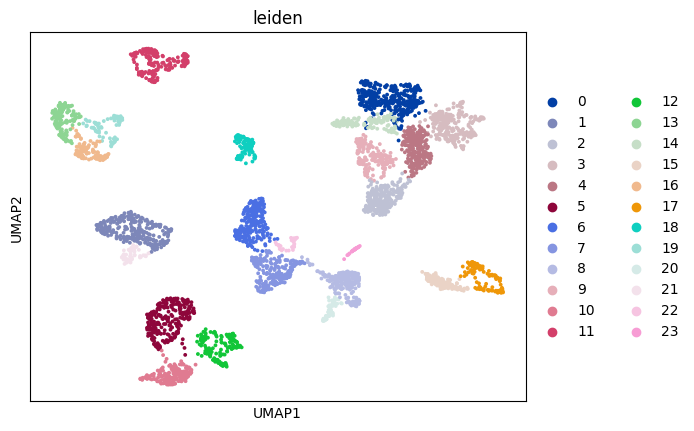

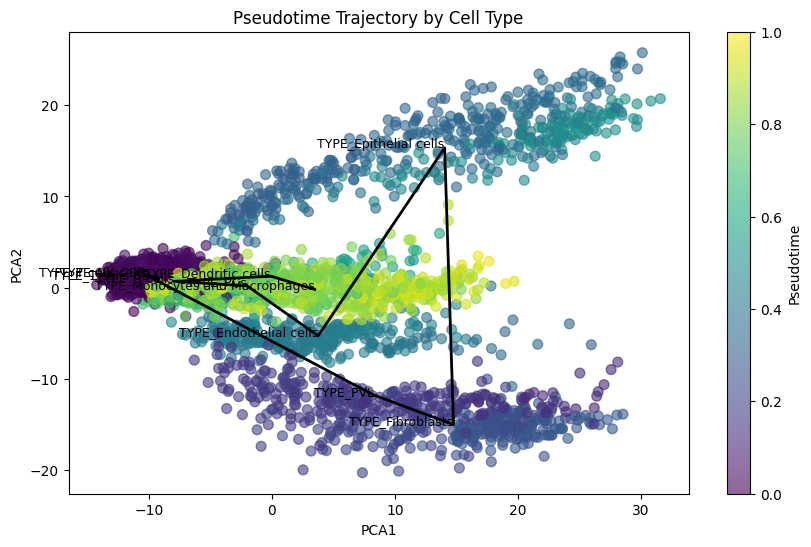

In [ ]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 读取数据
scadata = sc.read_h5ad('/data/Celloc-main/data/CytoSPACE_example_breast_cancer/scRNA.h5ad')

# 数据预处理
sc.pp.normalize_total(scadata, target_sum=1e4)
sc.pp.log1p(scadata)
sc.pp.highly_variable_genes(scadata, min_mean=0.0125, max_mean=3, min_disp=0.5)
scadata = scadata[:, scadata.var.highly_variable]
sc.pp.scale(scadata, max_value=10)
sc.tl.pca(scadata, svd_solver='arpack')
sc.pp.neighbors(scadata, n_neighbors=10, n_pcs=40)
sc.tl.umap(scadata)
sc.tl.leiden(scadata)

# 可视化UMAP聚类结果
sc.pl.umap(scadata, color=['leiden'])

# 选择起始细胞
root_cell = np.where(scadata.obs['leiden'] == '0')[0][0]  # 修改 '0' 为适合你数据的类簇

# 设置根细胞
scadata.uns['iroot'] = root_cell

# 计算拟时序
sc.tl.dpt(scadata)

# 确保 CellType 列存在
if 'CellType' in scadata.obs.columns:
    # 获取拟时序值和PCA坐标
    pseudotime = scadata.obs['dpt_pseudotime'].values
    pca_coords = scadata.obsm['X_pca'][:, :2]

    # 获取每个细胞类型的平均坐标
    cell_types = scadata.obs['CellType'].unique()
    avg_coords = {cell_type: np.mean(pca_coords[scadata.obs['CellType'] == cell_type], axis=0) for cell_type in cell_types}
    avg_pseudotime = {cell_type: np.mean(pseudotime[scadata.obs['CellType'] == cell_type]) for cell_type in cell_types}

    # 按拟时序值对细胞类型排序
    sorted_cell_types = sorted(cell_types, key=lambda x: avg_pseudotime[x])

    # 获取排序后的坐标
    sorted_avg_coords = np.array([avg_coords[cell_type] for cell_type in sorted_cell_types])

    # 绘制PCA图，并沿细胞类型的平均坐标绘制轨迹线
    plt.figure(figsize=(10, 6))
    plt.scatter(pca_coords[:, 0], pca_coords[:, 1], c=pseudotime, cmap='viridis', alpha=0.6, s=50)
    plt.plot(sorted_avg_coords[:, 0], sorted_avg_coords[:, 1], color='black', lw=2)
    for cell_type, (x, y) in zip(sorted_cell_types, sorted_avg_coords):
        plt.text(x, y, cell_type, fontsize=9, ha='right')
    plt.colorbar(label='Pseudotime')
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.title('Pseudotime Trajectory by Cell Type')
    plt.show()
else:
    print("CellType列不存在于scadata.obs中，请检查数据。")


/root/anaconda3/envs/SPACEL/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/root/anaconda3/envs/SPACEL/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


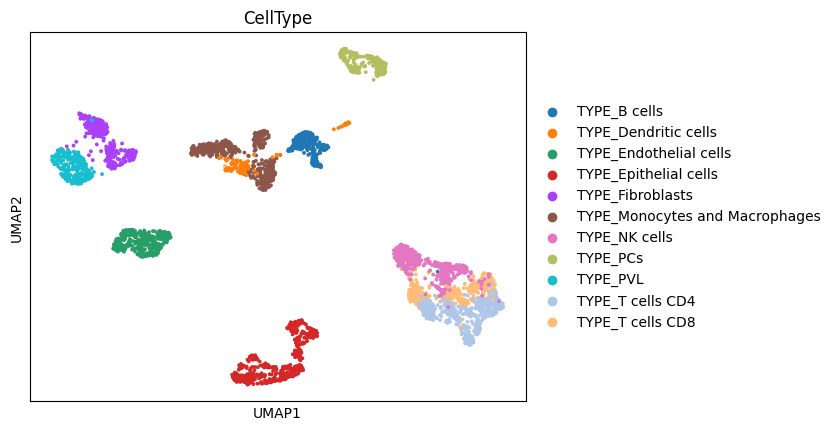

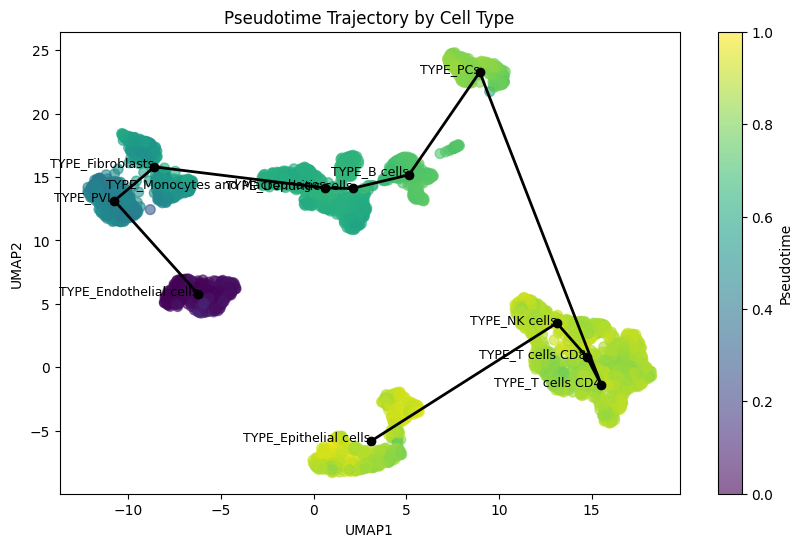

In [ ]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 读取数据
scadata = sc.read_h5ad('/data/Celloc-main/data/CytoSPACE_example_breast_cancer/scRNA.h5ad')

# 数据预处理
sc.pp.normalize_total(scadata, target_sum=1e4)
sc.pp.log1p(scadata)
sc.pp.highly_variable_genes(scadata, min_mean=0.0125, max_mean=3, min_disp=0.5)
scadata = scadata[:, scadata.var.highly_variable]
sc.pp.scale(scadata, max_value=10)
sc.tl.pca(scadata, svd_solver='arpack')
sc.pp.neighbors(scadata, n_neighbors=50, n_pcs=40)
sc.tl.umap(scadata, min_dist=0.5)
sc.tl.leiden(scadata)

# 可视化UMAP聚类结果
sc.pl.umap(scadata, color=['CellType'])

# 选择起始细胞
root_cell = np.where(scadata.obs['CellType'] == 'TYPE_Endothelial cells')[0][0]

# 设置根细胞
scadata.uns['iroot'] = root_cell

# 计算拟时序
sc.tl.dpt(scadata)

# 确保 CellType 列存在
if 'CellType' in scadata.obs.columns:
    # 获取拟时序值和UMAP坐标
    pseudotime = scadata.obs['dpt_pseudotime'].values
    umap_coords = scadata.obsm['X_umap'][:, :2]

    # 获取每个细胞类型的平均坐标
    cell_types = scadata.obs['CellType'].unique()
    avg_coords = {cell_type: np.mean(umap_coords[scadata.obs['CellType'] == cell_type], axis=0) for cell_type in cell_types}
    avg_pseudotime = {cell_type: np.mean(pseudotime[scadata.obs['CellType'] == cell_type]) for cell_type in cell_types}

    # 按拟时序值对细胞类型排序
    sorted_cell_types = sorted(cell_types, key=lambda x: avg_pseudotime[x])

    # 获取排序后的坐标
    sorted_avg_coords = np.array([avg_coords[cell_type] for cell_type in sorted_cell_types])

    # 绘制UMAP图，并沿细胞类型的平均坐标绘制轨迹线
    plt.figure(figsize=(10, 6))
    plt.scatter(umap_coords[:, 0], umap_coords[:, 1], c=pseudotime, cmap='viridis', alpha=0.6, s=50)
    plt.plot(sorted_avg_coords[:, 0], sorted_avg_coords[:, 1], color='black', lw=2, marker='o')
    for cell_type, (x, y) in zip(sorted_cell_types, sorted_avg_coords):
        plt.text(x, y, cell_type, fontsize=9, ha='right')
    plt.colorbar(label='Pseudotime')
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.title('Pseudotime Trajectory by Cell Type')
    plt.show()
else:
    print("CellType列不存在于scadata.obs中，请检查数据。")


/root/anaconda3/envs/SPACEL/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


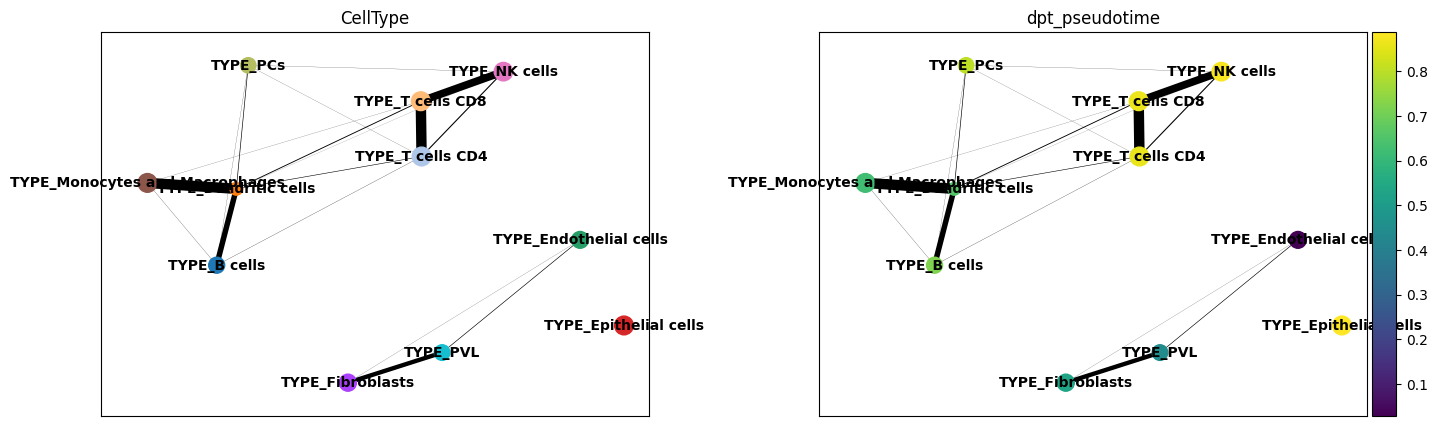

/root/anaconda3/envs/SPACEL/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


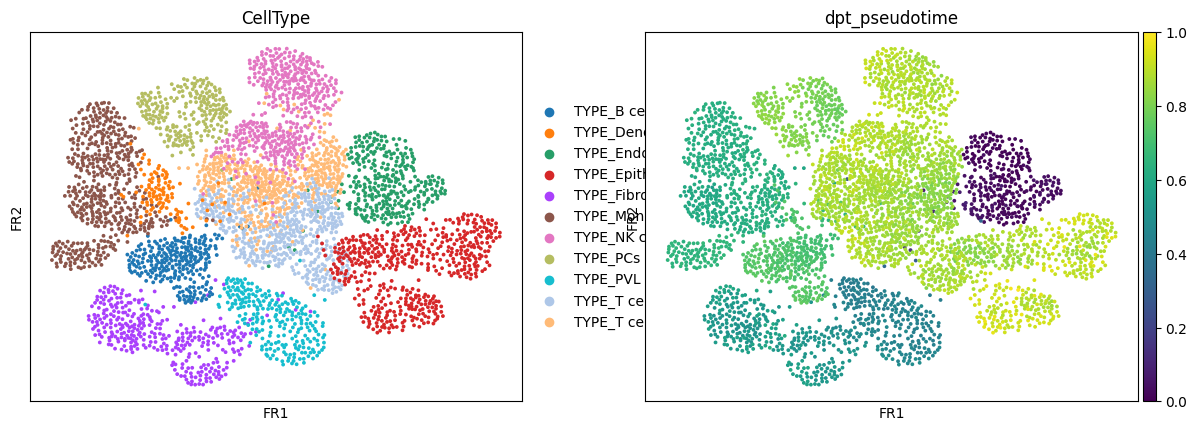

/root/anaconda3/envs/SPACEL/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/tmp/ipykernel_253840/3865173176.py:42: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_253840/3865173176.py:48: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


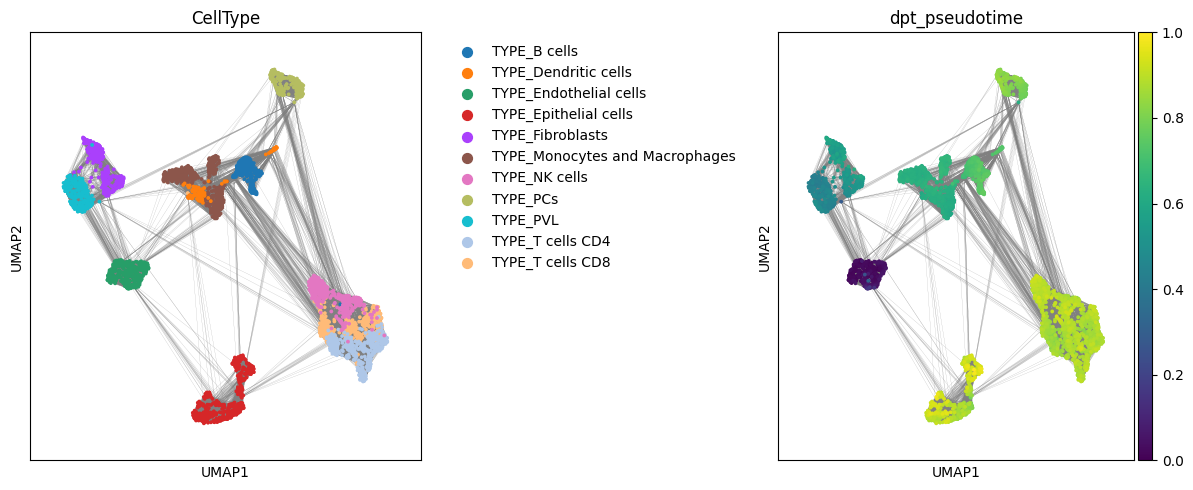

/root/anaconda3/envs/SPACEL/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/tmp/ipykernel_253840/3865173176.py:59: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_253840/3865173176.py:64: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


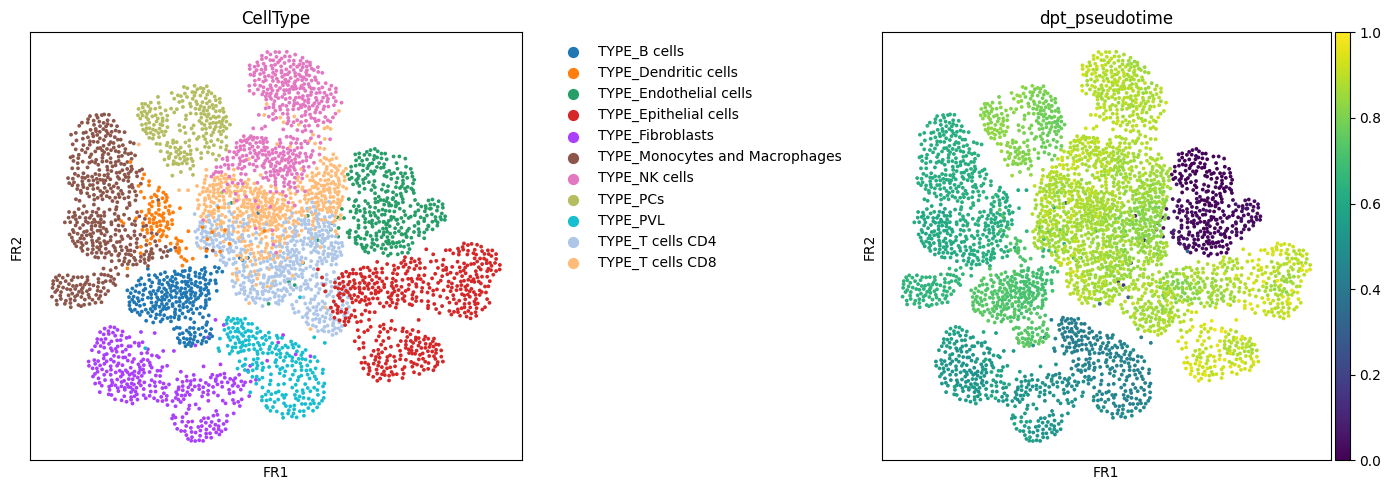

/root/anaconda3/envs/SPACEL/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/tmp/ipykernel_253840/3865173176.py:78: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_253840/3865173176.py:83: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


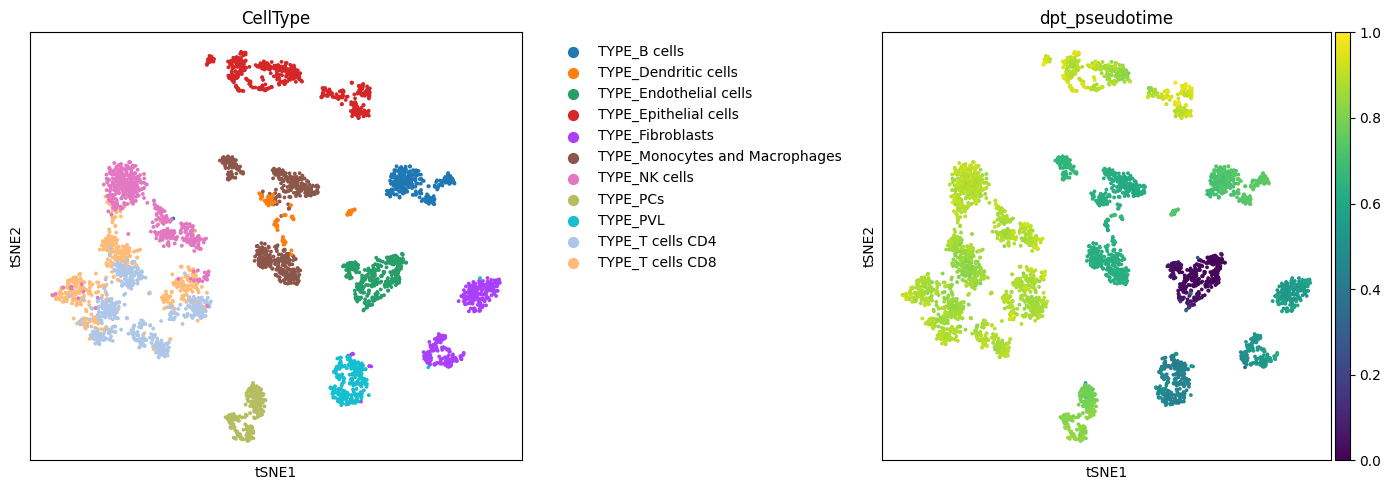

In [ ]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 读取数据
scadata = sc.read_h5ad('/data/Celloc-main/data/CytoSPACE_example_breast_cancer/scRNA.h5ad')

# 数据预处理
sc.pp.normalize_total(scadata, target_sum=1e4)
sc.pp.log1p(scadata)
sc.pp.highly_variable_genes(scadata, min_mean=0.0125, max_mean=3, min_disp=0.5)
scadata = scadata[:, scadata.var.highly_variable]
sc.pp.scale(scadata, max_value=10)
sc.tl.pca(scadata, svd_solver='arpack')
sc.pp.neighbors(scadata, n_neighbors=50, n_pcs=40)
sc.tl.umap(scadata, min_dist=0.5)
sc.tl.leiden(scadata)

# 选择起始细胞
root_cell = np.where(scadata.obs['CellType'] == 'TYPE_Endothelial cells')[0][0]

# 设置根细胞
scadata.uns['iroot'] = root_cell

# 计算拟时序和PAGA
sc.tl.dpt(scadata)
sc.tl.paga(scadata, groups='CellType')
sc.pl.paga(scadata, color=['CellType', 'dpt_pseudotime'])

# 在UMAP图上显示PAGA结果
sc.tl.draw_graph(scadata, init_pos='paga')
sc.pl.draw_graph(scadata, color=['CellType', 'dpt_pseudotime'])

# 显示UMAP和PAGA结合的图
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# 绘制CellType图
sc.pl.umap(scadata, color=['CellType'], edges=True, ax=ax[0], show=False)
legend = ax[0].legend(loc='upper left', bbox_to_anchor=(1.05, 1), frameon=False)
for handle in legend.legendHandles:
    handle.set_sizes([50])

# 绘制dpt_pseudotime图
sc.pl.umap(scadata, color=['dpt_pseudotime'], edges=True, ax=ax[1], show=False)
legend = ax[1].legend(loc='upper left', bbox_to_anchor=(1.05, 1), frameon=False)
for handle in legend.legendHandles:
    handle.set_sizes([50])

plt.tight_layout()
plt.show()

# 在force-directed图上显示PAGA结果
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sc.pl.draw_graph(scadata, color=['CellType'], ax=ax[0], show=False)
legend = ax[0].legend(loc='upper left', bbox_to_anchor=(1.05, 1), frameon=False)
for handle in legend.legendHandles:
    handle.set_sizes([50])

sc.pl.draw_graph(scadata, color=['dpt_pseudotime'], ax=ax[1], show=False)
legend = ax[1].legend(loc='upper left', bbox_to_anchor=(1.05, 1), frameon=False)
for handle in legend.legendHandles:
    handle.set_sizes([50])

plt.tight_layout()
plt.show()

# 计算 t-SNE 坐标
sc.tl.tsne(scadata)

# 显示 t-SNE 图
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sc.pl.tsne(scadata, color=['CellType'], ax=ax[0], show=False)
legend = ax[0].legend(loc='upper left', bbox_to_anchor=(1.05, 1), frameon=False)
for handle in legend.legendHandles:
    handle.set_sizes([50])

sc.pl.tsne(scadata, color=['dpt_pseudotime'], ax=ax[1], show=False)
legend = ax[1].legend(loc='upper left', bbox_to_anchor=(1.05, 1), frameon=False)
for handle in legend.legendHandles:
    handle.set_sizes([50])

plt.tight_layout()
plt.show()


In [ ]:
['EEF1A1', 'RPL10', 'RPL13A', 'RPLP1', 'TMSB4X', 'RPS2', 'MT-CO1', 'RPS18', 'RPL13', 'VIM', 'TPT1', 'MT-CO3', 'RPS12', 'RPS4X', 'RPL41', 'TMSB10', 'RPS23', 'RPL32', 'RPS14', 'RPS8'

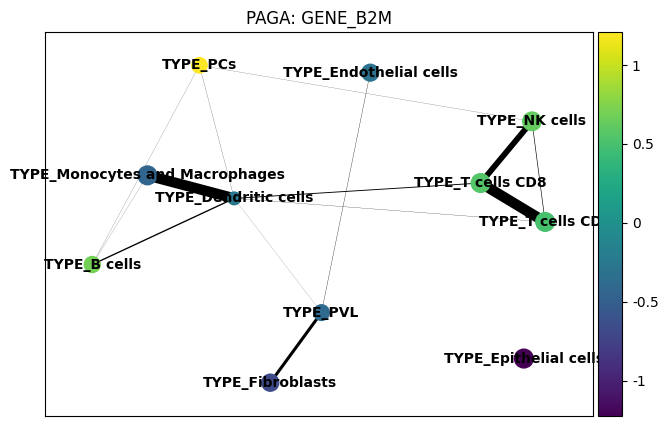

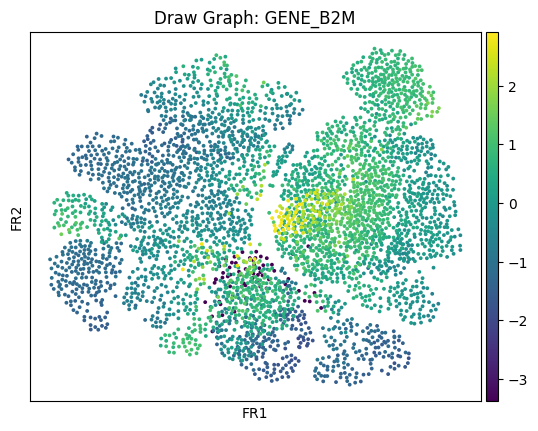

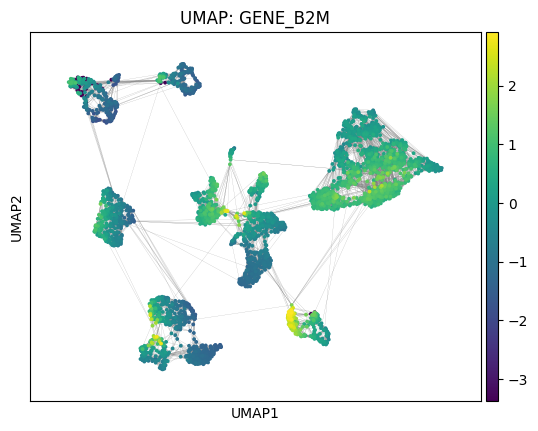

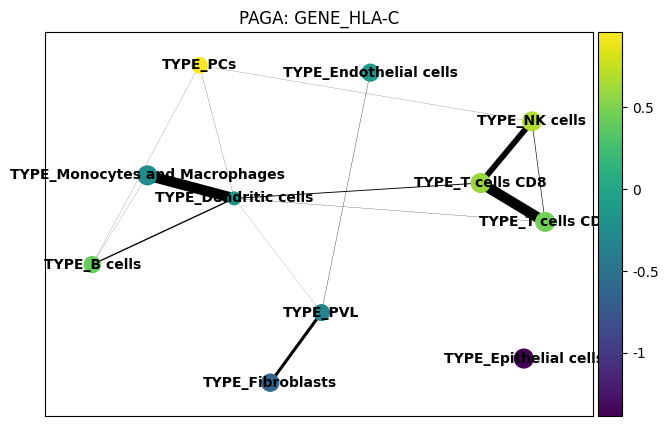

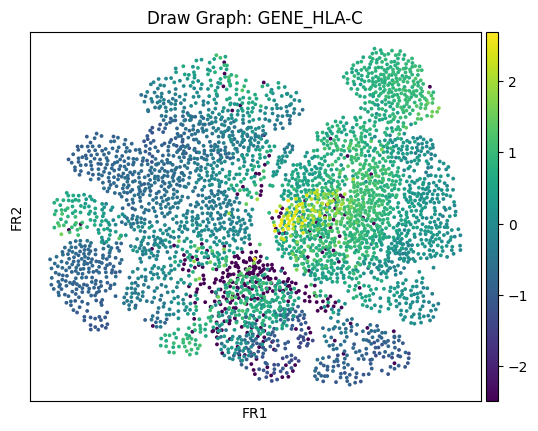

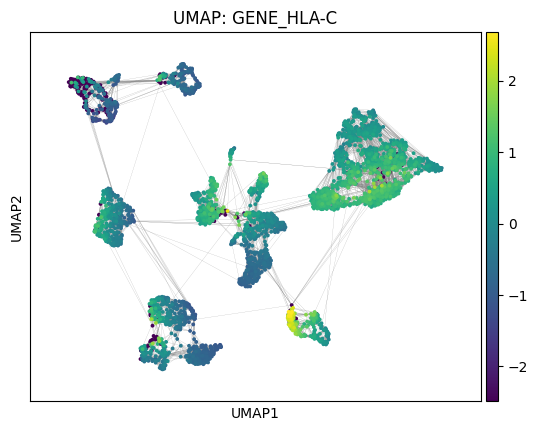

In [ ]:
# 绘制特定基因在拟时序轨迹上的表达变化
genes = ['GENE_B2M', 'GENE_HLA-C']
for gene in genes:
    sc.pl.paga(scadata, color=gene, title=f'PAGA: {gene}')
    sc.pl.draw_graph(scadata, color=gene, title=f'Draw Graph: {gene}')
    sc.pl.umap(scadata, color=gene, edges=True, title=f'UMAP: {gene}')

/root/anaconda3/envs/SPACEL/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


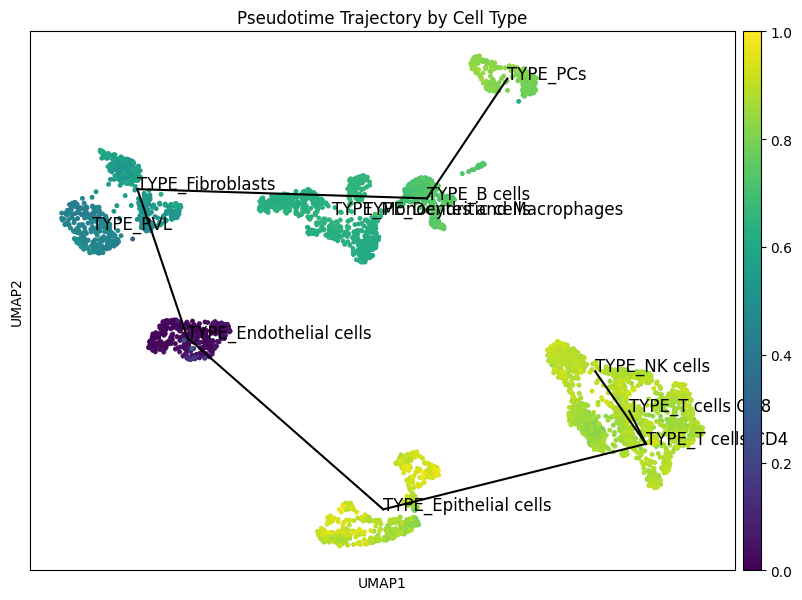

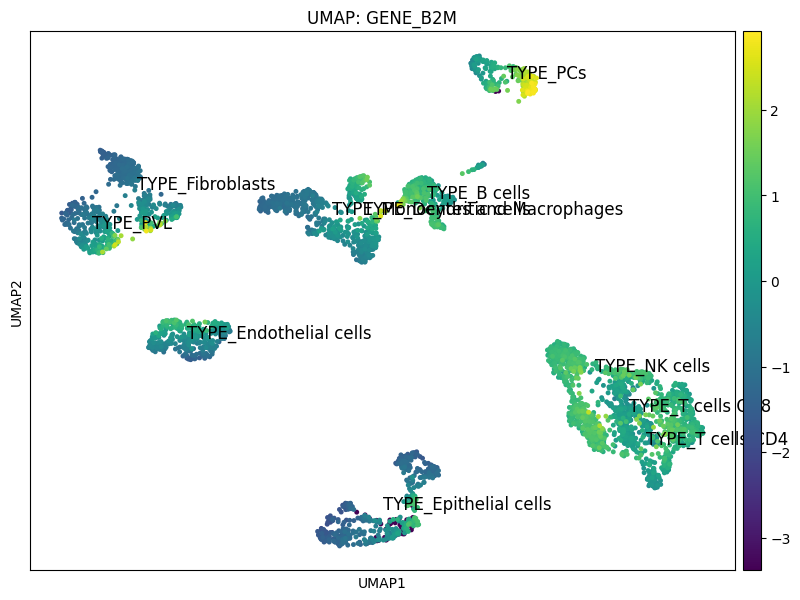

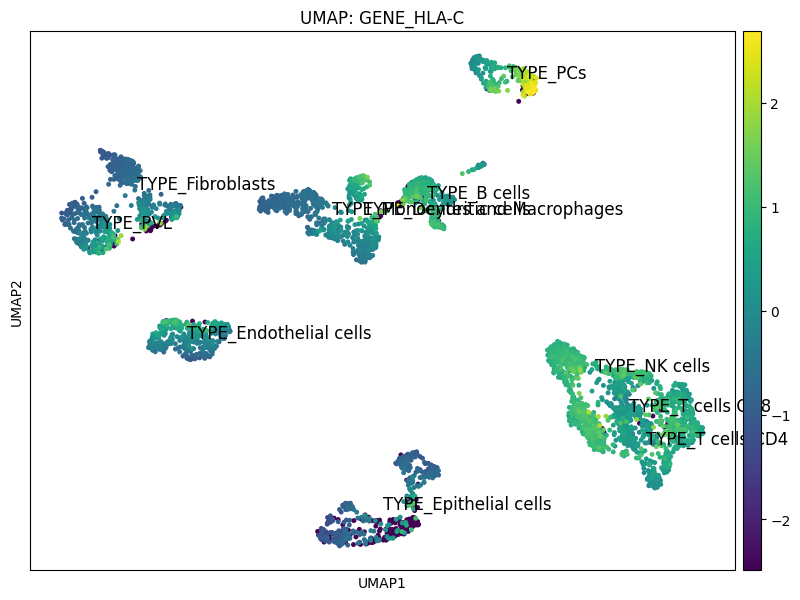

In [ ]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 读取数据
scadata = sc.read_h5ad('/data/Celloc-main/data/CytoSPACE_example_breast_cancer/scRNA.h5ad')

# 数据预处理
sc.pp.normalize_total(scadata, target_sum=1e4)
sc.pp.log1p(scadata)
sc.pp.highly_variable_genes(scadata, min_mean=0.0125, max_mean=3, min_disp=0.5)
scadata = scadata[:, scadata.var.highly_variable]
sc.pp.scale(scadata, max_value=10)
sc.tl.pca(scadata, svd_solver='arpack')
sc.pp.neighbors(scadata, n_neighbors=50, n_pcs=40)
sc.tl.umap(scadata, min_dist=0.5)
sc.tl.leiden(scadata)

# 选择起始细胞
root_cell = np.where(scadata.obs['CellType'] == 'TYPE_Endothelial cells')[0][0]

# 设置根细胞
scadata.uns['iroot'] = root_cell

# 计算拟时序
sc.tl.dpt(scadata)

# 绘制细胞类型和拟时序的UMAP图
fig, ax = plt.subplots(figsize=(10, 7))

# 绘制 UMAP 图
sc.pl.umap(scadata, color='dpt_pseudotime', ax=ax, show=False, size=50)

# 手动添加分支连接线
# 根据具体的细胞类型坐标，添加连接线
connections = [
    ('TYPE_Endothelial cells', 'TYPE_Fibroblasts'),
    ('TYPE_Fibroblasts', 'TYPE_B cells'),
    ('TYPE_B cells', 'TYPE_PCs'),
    ('TYPE_Endothelial cells', 'TYPE_Epithelial cells'),
    ('TYPE_Epithelial cells', 'TYPE_T cells CD4'),
    ('TYPE_T cells CD4', 'TYPE_T cells CD8'),
    ('TYPE_T cells CD4', 'TYPE_NK cells'),
]

# 获取细胞类型的UMAP坐标
celltype_coords = scadata.obs[['CellType']].join(pd.DataFrame(scadata.obsm['X_umap'], index=scadata.obs.index))

# 计算每个细胞类型的平均坐标
mean_coords = celltype_coords.groupby('CellType').mean()

for start, end in connections:
    start_coords = mean_coords.loc[start].values
    end_coords = mean_coords.loc[end].values
    ax.plot([start_coords[0], end_coords[0]], [start_coords[1], end_coords[1]], 'k-')

# 添加细胞类型标签
for celltype, coords in mean_coords.iterrows():
    ax.text(coords[0], coords[1], celltype, fontsize=12)

plt.title("Pseudotime Trajectory by Cell Type")
plt.show()

# 绘制特定基因在拟时序轨迹上的表达变化
genes = ['GENE_B2M', 'GENE_HLA-C']
for gene in genes:
    fig, ax = plt.subplots(figsize=(10, 7))
    sc.pl.umap(scadata, color=gene, edges=False, ax=ax, show=False, size=50)  # 不绘制连接线
    for celltype, coords in mean_coords.iterrows():
        ax.text(coords[0], coords[1], celltype, fontsize=12)
    plt.title(f"UMAP: {gene}")
    plt.show()
